In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

okt = Okt()
enc = OneHotEncoder()
tokenizer = Tokenizer()
stopwords = [
    "의",
    "가",
    "이",
    "은",
    "들",
    "는",
    "좀",
    "잘",
    "걍",
    "과",
    "도",
    "를",
    "으로",
    "자",
    "에",
    "와",
    "한",
    "하다",
]
best_model_path = "./best_model.keras"

vas = pd.read_csv("./vas.csv", encoding="CP949")


def vas_remap(x):
    if x <= 1:
        return 0
    elif x <= 4:
        return 1
    elif x <= 7:
        return 2
    return 3


vas["vas"] = vas["vas"].apply(vas_remap)

In [2]:
input_array = np.array(vas["vas"]).reshape(-1, 1)

enc.fit(input_array)

y_ori = enc.transform(input_array).toarray()

X = []

for sentence in tqdm(vas["symptom"]):
    tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화
    stopwords_removed_sentence = [
        word for word in tokenized_sentence if not word in stopwords
    ]  # 불용어 제거
    X.append(stopwords_removed_sentence)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_ori, random_state=12345, shuffle=True, test_size=0.1
)

tokenizer.fit_on_texts(X_train)

  0%|          | 0/724 [00:00<?, ?it/s]

100%|██████████| 724/724 [00:02<00:00, 316.24it/s]


In [5]:
threshold = 3
total_cnt = len(tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print("등장 빈도가 %s번 이하인 희귀 단어의 수: %s" % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 275
등장 빈도가 2번 이하인 희귀 단어의 수: 171
단어 집합에서 희귀 단어의 비율: 62.18181818181818
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 17.19383617193836


In [6]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print("단어 집합의 크기 :", vocab_size)

단어 집합의 크기 : 105


In [7]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

최대 길이 : 16
평균 길이 : 9.723809523809523


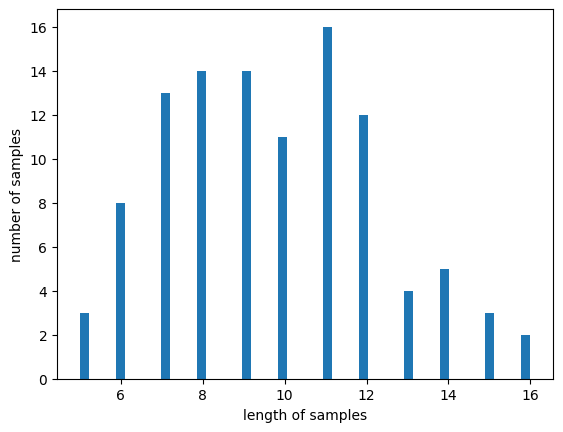

In [8]:
# print('최대 길이 :',max(len(review) for review in X_train))
# print('평균 길이 :',sum(map(len, X_train))/len(X_train))
# plt.hist([len(review) for review in X_train], bins=50)
# plt.xlabel('length of samples')
# plt.ylabel('number of samples')
# plt.show()

In [9]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if len(sentence) <= max_len:
            count = count + 1
    print(
        "전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s"
        % (max_len, (count / len(nested_list)) * 100)
    )

In [10]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [11]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [12]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation="softmax"))

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=4)
mc = ModelCheckpoint(
    best_model_path, monitor="val_acc", mode="max", verbose=1, save_best_only=True
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
print(model.summary())
history = model.fit(
    X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[es, mc]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         10500     
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 53000 (207.03 KB)
Trainable params: 53000 (207.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/30
1/3 [=========>....................] - ETA: 4s - loss: 1.3898 - acc: 0.0938
Epoch 1: val_acc improved from -inf to 0.33333, saving model to C:/Users/user/Documents\best_model.h5
3/3 [==============================] - 3s 309ms/step - loss: 1.3857 - acc: 0.2143 - val_

C:\Users\All Users\anaconda3\envs\distilkobert\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_acc did not improve from 0.33333
3/3 [==============================] - 0s 38ms/step - loss: 1.3588 - acc: 0.3810 - val_loss: 1.3602 - val_acc: 0.2857
Epoch 4/30
1/3 [=========>....................] - ETA: 0s - loss: 1.3381 - acc: 0.3438
Epoch 4: val_acc did not improve from 0.33333
3/3 [==============================] - 0s 33ms/step - loss: 1.3380 - acc: 0.3571 - val_loss: 1.3515 - val_acc: 0.2857
Epoch 5/30
1/3 [=========>....................] - ETA: 0s - loss: 1.3219 - acc: 0.3125
Epoch 5: val_acc did not improve from 0.33333
3/3 [==============================] - 0s 31ms/step - loss: 1.3210 - acc: 0.3571 - val_loss: 1.3475 - val_acc: 0.2857
Epoch 6/30
1/3 [=========>....................] - ETA: 0s - loss: 1.3491 - acc: 0.2500
Epoch 6: val_acc did not improve from 0.33333
3/3 [==============================] - 0s 32ms/step - loss: 1.3133 - acc: 0.3571 - val_loss: 1.3493 - val_acc: 0.2857
Epoch 7/30
1/3 [=========>....................] - ETA: 0s - loss: 1.3089 - acc: 0.

In [13]:
loaded_model = load_model(best_model_path)
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd5 in position 28: invalid continuation byte -> 경로에 띄어쓰기 등이 있으면 발생하는 에러

1/1 [==============================] - 0s 352ms/step - loss: 0.5699 - acc: 0.9167

 테스트 정확도: 0.9167


In [14]:
# 토크나이저 백업
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle)

with open("tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

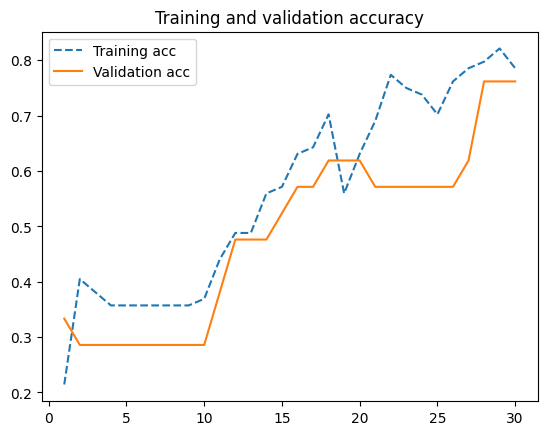

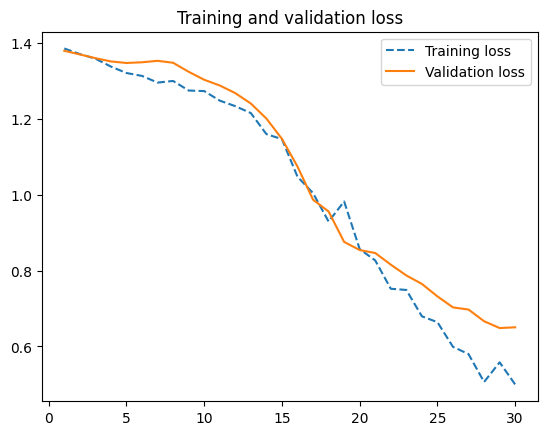

In [22]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "--", label="Training acc")
plt.plot(epochs, val_acc, label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "--", label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [16]:
vas

,symptom,vas
0,"아침에 깨어났을 때 치아에 전혀 문제가 없어요, 아무 느낌도 없습니다.",0
1,"가끔 치아가 살짝 아릴 때가 있지만, 거의 주목하지 않아도 됩니다.",0
2,차가운 음료를 마실 때 가끔 치아가 미세하게 민감해집니다.,1
3,"얼음을 먹으면 잠깐 치아가 아프지만, 곧 나아집니다.",1
4,씹을 때마다 가끔 어금니가 약간 불편하게 느껴집니다.,1
...,...,...
112,치아 통증이 너무 심해서 말하기도 힘들어요.,3
113,가끔 치아가 약간 아플 때가 있어요.,1
114,식사할 때마다 이가 불편하고 아파요.,2
115,치아에 지속적인 중간 정도의 통증이 있어요.,2


In [17]:
new_sentence = "식사할 때마다 이가 불편하고 아파요."

new_sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", new_sentence)
new_sentence = okt.morphs(new_sentence, stem=True)  # 토큰화
new_sentence = [word for word in new_sentence if not word in stopwords]  # 불용어 제거
encoded = tokenizer.texts_to_sequences([new_sentence])  # 정수 인코딩
pad_new = pad_sequences(encoded, maxlen=max_len)  # 패딩
score = loaded_model.predict(pad_new)  # 예측

1/1 [==============================] - 0s 276ms/step


In [18]:
score

array([[0.03706696, 0.2368438 , 0.7039124 , 0.02217695]], dtype=float32)

In [19]:
np.argmax(score)

2